In [1]:
import os
import tkinter
import numpy as np
import random as r

import pandas as pd  # For reading CSV files
import time

from pandas.core.frame import DataFrame
from plotgen import Window
from LRModel import Model

# Path to all CSVs
DATA_PATH = "csv_data"


def read_records():
    all_records = []
    length = 0

    # Array containing a list of CSV files:
    record_data = os.listdir(DATA_PATH)

    for record in record_data:
        print("Reading " + record)
        data = pd.read_csv(DATA_PATH + "/" + record)
        length += data.shape[0]
        all_records.append(data)

    # Create the dataframe and return it.
    all_records = pd.concat(all_records, axis=0, ignore_index=True)
    print("Total number of rows: {}".format(length))
    return all_records


def test_data(num_records):
    races = ['A', 'B', 'C', 'D']
    sexs = ['F','M']

    dtypes = np.dtype(
        [
            ("sex", str),
            ("age", int),
            ("race", str),
            ("juv_fel_count", int),
            ("juv_misd_count", int),
            ("juv_other_count", int),
            ("priors_count", int),
            ("days_b_screening_arrest", int),
            ("c_days_from_compas", int),
            ("c_charge_degree", str),
            ("is_recid", int),
            ("r_charge_degree", str),
            ("decile_score", int)
        ]
    )

    data = np.empty(0,dtype=dtypes)
    testframe = DataFrame(data)
    
    for i in range(num_records):
        race = r.choice(races)
        age = r.randint(18,80)
        sex = r.choice(sexs)
        record = rand_record(sex,age,race,testframe.columns)
        testframe = testframe.append(record, ignore_index=True)

    #print(testframe.shape)
    return testframe

def rand_record(sex,age,race,columns):
    record = [sex,age,race]

    #juv_fel_count
    record.append(int(r.randint(0,3)))
    #juv_misd_count
    record.append(r.randint(0,3))
    #juv_other_count
    record.append(r.randint(0,3))
    #priors_count
    record.append(r.randint(0,5))
    #days_b_screening_arrest
    record.append(r.randint(0,10))
    #c_days_from_compas
    record.append(r.randint(0,4))
    #c_charge_degree
    record.append(r.randint(0,3))
    #is_recid
    record.append(r.randint(0,1))
    #r_charge_degree
    if record[10] == 1:
        record.append(r.choice(['F','M']))
    else:
        record.append('')
    #decile_score
    score = 1
    if race == 'B':
        score += 2
    if race == 'C':
        score += 5
    if race == 'D':
        score += 8
    record.append(score)

    rec_dict = {columns[i]: record[i] for i in range(len(record))}
    
    return rec_dict


if __name__ == "__main__":
    start = time.time()
    nonlin = False # use nonlinear model instead of linear model?
    # root = tkinter.Tk()
    # window = Window(root, read_records())
    # tkinter.mainloop()

    # Random Dataframe
    # rand_model = Model(test_data(1000))
    # rand_model.convert_data()

    print('----------------')

    compas_model = Model(read_records())
    if nonlin:
        X_test, y_test, history = compas_model.convert_data()
    else:
        X_test, y_test = compas_model.convert_data()

    elapsed = time.time() - start
    print("\n\nScript execution time: {} seconds".format(elapsed))


----------------
Reading compas-scores-two-years.csv
Total number of rows: 7214
Original number of columns: 13
Spliting dataset 80/20...
(5525, 29) (1382, 29)
Training...
n_attributes (model input size): 29
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3000      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 8,101
Trainable params: 8,101
Non-trainable params: 0
_________________________________________________________________
val sample shape:
(1, 29)
Val MSE: 9.13


Script execution time: 53.20030903816223 seconds


In [2]:
# control for attribute (currently hardcoded to race) and compare scores
count = 0
recid_avg_race = [[],[],[],[]]
for i in range(len(X_test)):
    compas_score = y_test.iat[i, 0]
    sample = X_test.iloc[[i]]
    race_scores = compas_model.score_attribute(sample, compas_score) # input shape is a single df row and the recidivism score

    # calculate difference for each race from recid score filter, accurate predictions only
    acc_pred = False
    diffs = []
    for i in range(len(race_scores)):
        diff = race_scores[i] - compas_score
        if (abs(diff) < 10):
            acc_pred = True
        diffs.append(diff)

    # if the model accurately predicted the recid score, add the respective race differences to the tally
    if acc_pred == True:
        count += 1
        for i in range(len(diffs)):
            recid_avg_race[i].append(diffs[i])

print(len(X_test))
print("baseline Caucasian learned recidivism \nscore disparities by race:")
print("African American: " + str(round(np.mean(recid_avg_race[0]), 2)))
print("Hispanic: " + str(round(np.mean(recid_avg_race[1]), 2)))
print("Other: " + str(round(np.mean(recid_avg_race[3]), 2)))

    

compas score: 7
African-American score: 4.23
Hispanic score: 3.8
Caucasian score: 4.02
Other score: 3.96
---------------------------
compas score: 8
African-American score: 3.55
Hispanic score: 3.28
Caucasian score: 3.41
Other score: 3.28
---------------------------
compas score: 1
African-American score: 4.46
Hispanic score: 4.05
Caucasian score: 4.27
Other score: 4.23
---------------------------
compas score: 7
African-American score: 4.26
Hispanic score: 3.85
Caucasian score: 4.06
Other score: 3.99
---------------------------
compas score: 1
African-American score: 4.85
Hispanic score: 4.46
Caucasian score: 4.65
Other score: 4.61
---------------------------
compas score: 5
African-American score: 3.33
Hispanic score: 3.14
Caucasian score: 3.39
Other score: 3.35
---------------------------
compas score: 7
African-American score: 3.68
Hispanic score: 3.42
Caucasian score: 3.54
Other score: 3.39
---------------------------
compas score: 1
African-American score: 4.78
Hispanic score: 4.

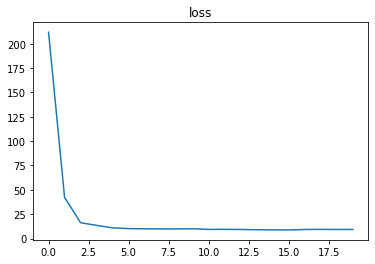

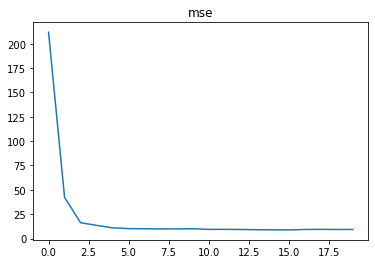

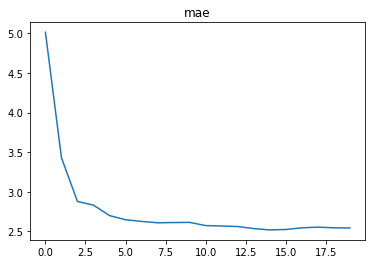

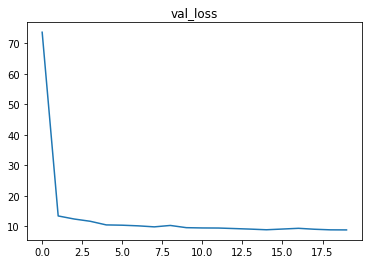

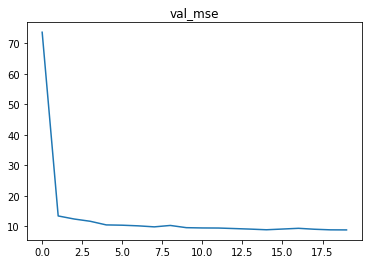

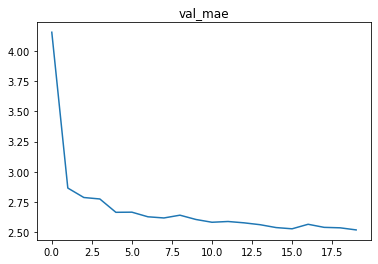

In [3]:
# This cell provides training and validation set loss, mse, and mae when training the nonlinear model
if nonlin:
    import matplotlib.pyplot as plt

    plt.plot(history.history['loss'])
    plt.title('loss')
    plt.show()

    plt.plot(history.history['mse'])
    plt.title('mse')
    plt.show()

    plt.plot(history.history['mae'])
    plt.title('mae')
    plt.show()

    plt.plot(history.history['val_loss'])
    plt.title('val_loss')
    plt.show()

    plt.plot(history.history['val_mse'])
    plt.title('val_mse')
    plt.show()

    plt.plot(history.history['val_mae'])
    plt.title('val_mae')
    plt.show()
